# CV playground

Это проект, в котором я подробно изучаю различные архитектуры, алгоритмы и метрики DL

## Imports + setup

In [38]:
import os, json, time, random
from dataclasses import asdict, dataclass
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def set_seed(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@dataclass 
class Config:
    exp_name: str = 'debug'
    seed: int = 42
    epochs: int = 10
    batch_size: int = 128
    lr: float = 1e-3
    weight_decay: float = 0.0
    num_workers: int = 0
    val_split: int = 5000

CFG = Config()
set_seed(CFG.seed)

In [4]:
DATA_DIR = Path("./data")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"
RUNS_DIR = Path("runs")
RUNS_DIR.mkdir(parents=True, exist_ok=True)

def make_exp_name(cfg: Config) -> str:
    bn = "bn" if cfg.use_bn else "nobn"
    return f"{cfg.model}_{bn}_lr{cfg.lr}_bs{cfg.batch_size}_seed{cfg.seed}"

def make_run_dir(cfg: Config) -> Path:
    ts = time.strftime('%Y%m%d_%H%M%S')
    run_dir  = RUNS_DIR / f'{cfg.exp_name}_{ts}'
    run_dir.mkdir(parents=True, exist_ok=False)
    with open(run_dir / 'config.json', 'w', encoding='utf-8') as f:
        json.dump(asdict(cfg), f, indent=2, ensure_ascii=False)
    return run_dir

In [5]:
import matplotlib.pyplot as plt

def plot_history(history, title="", run_dir=None):

    plt.style.use("dark_background")
    
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(f"{title} | Loss" if title else "Loss")
    plt.legend()
    plt.grid(True)

    if run_dir is not None:
        plt.savefig(run_dir / "loss_curve.png", dpi=150, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(f"{title} | Accuracy" if title else "Accuracy")
    plt.legend()
    plt.grid(True)

    if run_dir is not None:
        plt.savefig(run_dir / "acc_curve.png", dpi=150, bbox_inches="tight")
    plt.show()


## Data preparation

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

In [ ]:
trains_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

train_full_aug = datasets.ImageFolder(root=str(TRAIN_DIR), transform=trains_tfms)
train_full_noaug = datasets.ImageFolder(root=str(TRAIN_DIR), transform=val_tfms)
test_ds = datasets.ImageFolder(root=str(TEST_DIR), transform=val_tfms)

In [8]:
CLASSES = train_full_aug.classes
print('num classes:', len(CLASSES))
print('classes:', CLASSES)
print('train_size:', len(train_full_aug), 'test_size:', len(test_ds))

num classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_size: 50000 test_size: 10000


In [9]:
val_size = CFG.val_split
train_size = len(train_full_aug) - val_size

g = torch.Generator().manual_seed(CFG.seed)

train_subset_aug, val_subset_indices = random_split(
    train_full_aug, [train_size, val_size], generator=g
)

val_indices = val_subset_indices.indices

val_subset_noaug = Subset(train_full_noaug, val_indices)
print('train/val sizes:', len(train_subset_aug), len(val_subset_noaug))

train/val sizes: 45000 5000


Dataloaders

In [10]:
train_loader = DataLoader(
    train_subset_aug, 
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    pin_memory=(device=='cuda')
)

val_loader = DataLoader(
    val_subset_noaug,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=(device=='cuda')
)

test_loader = DataLoader(
    test_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=(device=='cuda'),
)

## Метрики

In [11]:
def accuracy_top1(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds==y).float().mean().item()

## train/val loop

In [12]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_acc = 0.0
    total_loss = 0.0
    n_batches = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_top1(logits.detach(), yb)

        n_batches += 1
    
    avg_loss = total_loss / n_batches
    avg_acc = total_acc / n_batches

    return avg_loss, avg_acc
        

In [13]:
@torch.no_grad()
def validate(model, loader, criterion, device):

    model.eval()

    total_loss = 0
    total_acc = 0
    n_batches = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item()
        total_acc += accuracy_top1(logits, yb)
        
        n_batches +=1
    
    avg_loss = total_loss / n_batches
    avg_acc = total_acc / n_batches

    return avg_loss, avg_acc

In [14]:
def fit(model, train_loader, val_loader, optimizer, criterion, 
        device, epochs, run_dir=None, scheduler=None):
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    best_val_acc = -1

    pbar = tqdm(range(1, epochs+1), desc='Training', unit='epoch')

    for epoch in pbar:
        train_loss, train_acc  = train_one_epoch(model, train_loader,
                                          optimizer, criterion,
                                          device
                                          )
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step(val_loss)

        lr = optimizer.param_groups[0]['lr']

        pbar.set_postfix({
            "lr": f"{lr:.6f}",
            "tr_loss": f"{train_loss:.4f}",
            "tr_acc":  f"{train_acc :.4f}",
            "val_loss": f"{val_loss:.4f}",
            "val_acc":  f"{val_acc:.4f}",
            "best":    f"{max(history['val_acc']):.4f}",
        })

        tqdm.write(
            f"Epoch {epoch:02d}/{epochs} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | "
            f'lr={lr:.4f}'
        )


        if run_dir is not None and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "best_val_acc": best_val_acc,
                    "scheduler": scheduler.state_dict() if scheduler is not None else None
                },
                run_dir / "best.pt"
            )
    return history

## Models

In [15]:
class MLPBaseline(nn.Module):

    def __init__(self, num_classes=10, hidden1=512, hidden2=256):
        super().__init__()

        in_fetures = 3 * 32 * 32

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_fetures, hidden1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.8062, train_acc=0.3478 | val_loss=1.7337, val_acc=0.3898 | lr=0.0010
Epoch 02/10 | train_loss=1.6460, train_acc=0.4099 | val_loss=1.7110, val_acc=0.3885 | lr=0.0010
Epoch 03/10 | train_loss=1.5780, train_acc=0.4303 | val_loss=1.6185, val_acc=0.4201 | lr=0.0010
Epoch 04/10 | train_loss=1.5306, train_acc=0.4487 | val_loss=1.5907, val_acc=0.4391 | lr=0.0010
Epoch 05/10 | train_loss=1.5009, train_acc=0.4596 | val_loss=1.5747, val_acc=0.4420 | lr=0.0010
Epoch 06/10 | train_loss=1.4773, train_acc=0.4704 | val_loss=1.5675, val_acc=0.4393 | lr=0.0010
Epoch 07/10 | train_loss=1.4550, train_acc=0.4761 | val_loss=1.5502, val_acc=0.4568 | lr=0.0010
Epoch 08/10 | train_loss=1.4349, train_acc=0.4819 | val_loss=1.5938, val_acc=0.4441 | lr=0.0010
Epoch 09/10 | train_loss=1.4199, train_acc=0.4892 | val_loss=1.5821, val_acc=0.4391 | lr=0.0010
Epoch 10/10 | train_loss=1.4012, train_acc=0.4987 | val_loss=1.5520, val_acc=0.4521 | lr=0.0005


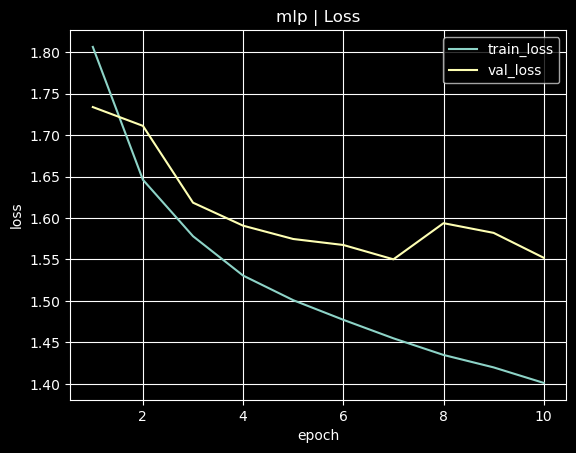

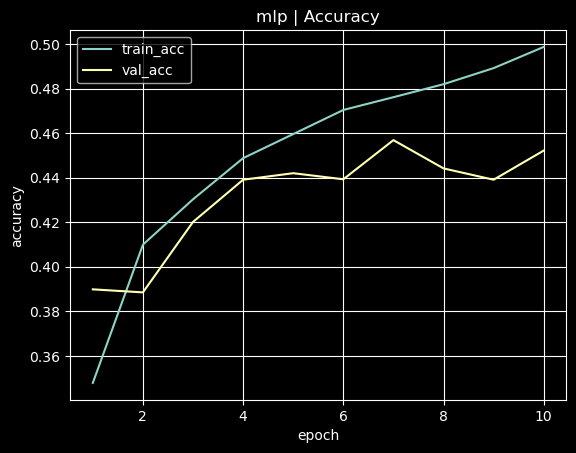

In [16]:
mlp_model = MLPBaseline().to(device)

mlp_criterion  = nn.CrossEntropyLoss()
mlp_optimizer  = torch.optim.Adam(
    mlp_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

mlp_scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
    mlp_optimizer ,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

mlp_run_dir = make_run_dir(CFG)
mlp_history = fit(mlp_model, train_loader, val_loader,
               mlp_optimizer , mlp_criterion, device,
               epochs=CFG.epochs, run_dir=mlp_run_dir,
               scheduler=mlp_scheduler 
)

plot_history(mlp_history, title='mlp', run_dir=mlp_run_dir)

In [17]:
class ConvBlock(nn.Module):

    def __init__(self, in_ch, out_ch, use_bn=True, k=3, p=1):
        super().__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)

        return x

class SimpleCNN(nn.Module):

    def __init__(self, num_classes=10, use_bn=True):
        super().__init__()

        self.block1 = ConvBlock(3, 32, use_bn)
        self.block2 = ConvBlock(32, 64, use_bn)
        self.block3 = ConvBlock(64, 128, use_bn)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Linear(128*8*8, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.pool(x)

        x = self.block3(x)
   
        x = x.flatten(1)
        logits = self.classifier(x)

        return logits

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4328, train_acc=0.4904 | val_loss=1.0912, val_acc=0.6148 | lr=0.0010
Epoch 02/10 | train_loss=1.0738, train_acc=0.6253 | val_loss=0.9197, val_acc=0.6830 | lr=0.0010
Epoch 03/10 | train_loss=0.9509, train_acc=0.6701 | val_loss=0.8688, val_acc=0.6943 | lr=0.0010
Epoch 04/10 | train_loss=0.8688, train_acc=0.6970 | val_loss=0.8099, val_acc=0.7270 | lr=0.0010
Epoch 05/10 | train_loss=0.8180, train_acc=0.7145 | val_loss=0.8008, val_acc=0.7371 | lr=0.0010
Epoch 06/10 | train_loss=0.7688, train_acc=0.7348 | val_loss=0.9391, val_acc=0.6912 | lr=0.0010
Epoch 07/10 | train_loss=0.7380, train_acc=0.7447 | val_loss=0.8463, val_acc=0.7293 | lr=0.0010
Epoch 08/10 | train_loss=0.7053, train_acc=0.7548 | val_loss=0.7843, val_acc=0.7480 | lr=0.0010
Epoch 09/10 | train_loss=0.6811, train_acc=0.7642 | val_loss=0.7533, val_acc=0.7539 | lr=0.0010
Epoch 10/10 | train_loss=0.6574, train_acc=0.7714 | val_loss=0.7102, val_acc=0.7672 | lr=0.0010


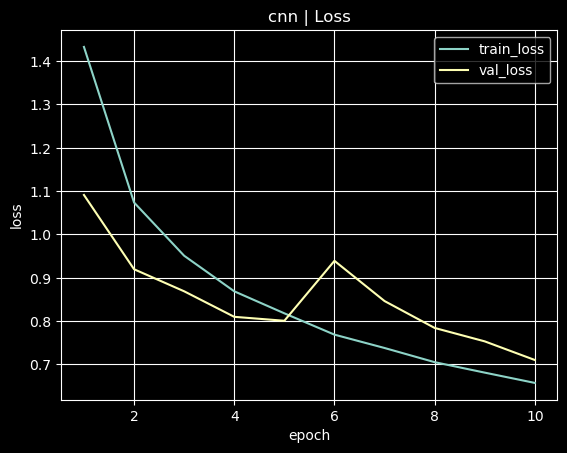

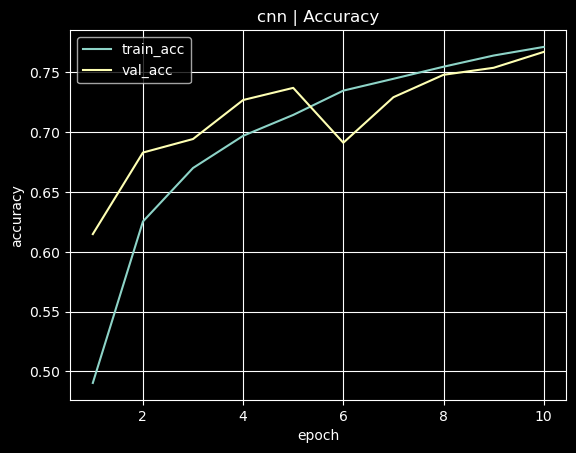

In [18]:
cnn_model = SimpleCNN(use_bn=True).to(device)

cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    cnn_optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

CFG.exp_name = "cnn"
cnn_run_dir = make_run_dir(CFG)
cnn_history = fit(
    cnn_model, train_loader, val_loader,
    cnn_optimizer, cnn_criterion, device,
    epochs=CFG.epochs, run_dir=cnn_run_dir, scheduler=cnn_scheduler
)

plot_history(cnn_history, title='cnn', run_dir=cnn_run_dir)

In [19]:
class ResidualBlock(nn.Module):

    def __init__(self, in_ch, out_ch, use_bn=True, stride=1):
        super().__init__()

        self.use_bn = use_bn

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
        self.act = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, stride=1, bias=not use_bn)
        self.bn2 = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()

        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=stride, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + identity

        out = self.act(out)
        
        return out
    

class SimpleResNet(nn.Module):

    def __init__(self, num_classes=10, use_bn=True):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, bias=not use_bn),
            nn.BatchNorm2d(32) if use_bn else nn.Identity(),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32, stride=1),
            ResidualBlock(32, 32, stride=1)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64, stride=1)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):

        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.gap(x)
        x = x.flatten(1)
        logits = self.fc(x)

        return logits

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4121, train_acc=0.4788 | val_loss=1.5073, val_acc=0.5311 | lr=0.0010
Epoch 02/10 | train_loss=0.9760, train_acc=0.6507 | val_loss=1.0593, val_acc=0.6367 | lr=0.0010
Epoch 03/10 | train_loss=0.8195, train_acc=0.7078 | val_loss=0.7879, val_acc=0.7307 | lr=0.0010
Epoch 04/10 | train_loss=0.7130, train_acc=0.7501 | val_loss=0.9348, val_acc=0.7021 | lr=0.0010
Epoch 05/10 | train_loss=0.6140, train_acc=0.7859 | val_loss=0.8268, val_acc=0.7375 | lr=0.0010
Epoch 06/10 | train_loss=0.5525, train_acc=0.8087 | val_loss=0.6924, val_acc=0.7750 | lr=0.0010
Epoch 07/10 | train_loss=0.5060, train_acc=0.8227 | val_loss=0.6720, val_acc=0.7951 | lr=0.0010
Epoch 08/10 | train_loss=0.4694, train_acc=0.8361 | val_loss=0.5755, val_acc=0.8135 | lr=0.0010
Epoch 09/10 | train_loss=0.4326, train_acc=0.8502 | val_loss=0.6734, val_acc=0.7850 | lr=0.0010
Epoch 10/10 | train_loss=0.4067, train_acc=0.8585 | val_loss=0.6061, val_acc=0.8031 | lr=0.0010


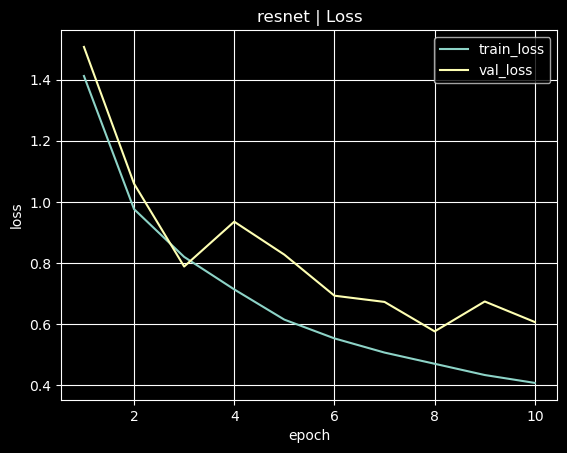

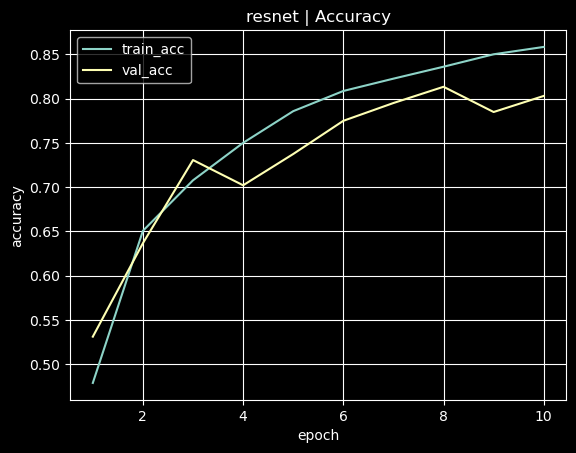

In [20]:
resnet_model = SimpleResNet(use_bn=True).to(device)

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(
    resnet_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

CFG.exp_name = "resnet"
resnet_run_dir = make_run_dir(CFG)
resnet_history = fit(
    resnet_model, train_loader, val_loader,
    resnet_optimizer, resnet_criterion, device,
    epochs=CFG.epochs, run_dir=resnet_run_dir, scheduler=resnet_scheduler
)

plot_history(resnet_history, title='resnet', run_dir=resnet_run_dir)


In [21]:
class VGGBlock(nn.Module):

    def __init__(self, in_ch, out_ch, n_convs, use_bn=True):
        super().__init__()

        layers = []
        ch = in_ch
        for _ in range(n_convs):
            layers.append(nn.Conv2d(ch, out_ch, kernel_size=3, padding=1, bias=not use_bn))
            layers.append(nn.BatchNorm2d(out_ch) if use_bn else nn.Identity())
            layers.append(nn.ReLU(inplace=True))
            ch = out_ch
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)
    

class MiniVGG(nn.Module):

    def __init__(self, num_classes=10, use_bn=True):
        super().__init__()

        self.b1 = VGGBlock(3, 64, n_convs=1)
        self.b2 = VGGBlock(64, 128, n_convs=1)
        self.b3 = VGGBlock(128, 256, n_convs=2)
        self.b4 = VGGBlock(256, 512, n_convs=2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)

        x = self.gap(x)
        x = x.flatten(1)
        logits = self.fc(x)

        return logits

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.3255, train_acc=0.5168 | val_loss=1.1180, val_acc=0.6156 | lr=0.0010
Epoch 02/10 | train_loss=0.8982, train_acc=0.6799 | val_loss=0.9687, val_acc=0.6600 | lr=0.0010
Epoch 03/10 | train_loss=0.7289, train_acc=0.7457 | val_loss=0.8024, val_acc=0.7229 | lr=0.0010
Epoch 04/10 | train_loss=0.6351, train_acc=0.7783 | val_loss=0.6766, val_acc=0.7664 | lr=0.0010
Epoch 05/10 | train_loss=0.5722, train_acc=0.8019 | val_loss=0.5704, val_acc=0.8102 | lr=0.0010
Epoch 06/10 | train_loss=0.5236, train_acc=0.8187 | val_loss=0.6824, val_acc=0.7740 | lr=0.0010
Epoch 07/10 | train_loss=0.4811, train_acc=0.8330 | val_loss=0.6721, val_acc=0.7770 | lr=0.0010
Epoch 08/10 | train_loss=0.4437, train_acc=0.8454 | val_loss=0.5500, val_acc=0.8164 | lr=0.0010
Epoch 09/10 | train_loss=0.4084, train_acc=0.8585 | val_loss=0.4823, val_acc=0.8393 | lr=0.0010
Epoch 10/10 | train_loss=0.3836, train_acc=0.8659 | val_loss=0.4749, val_acc=0.8432 | lr=0.0010


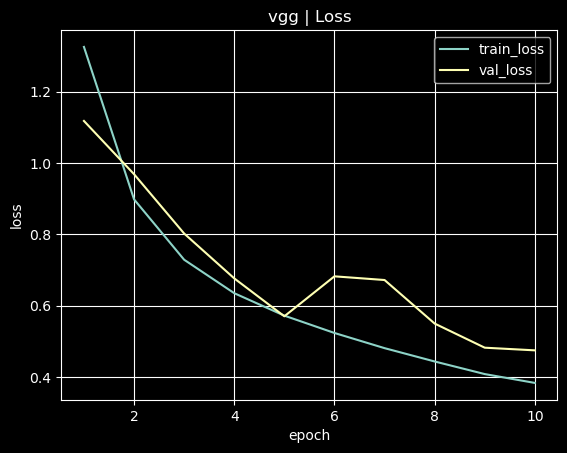

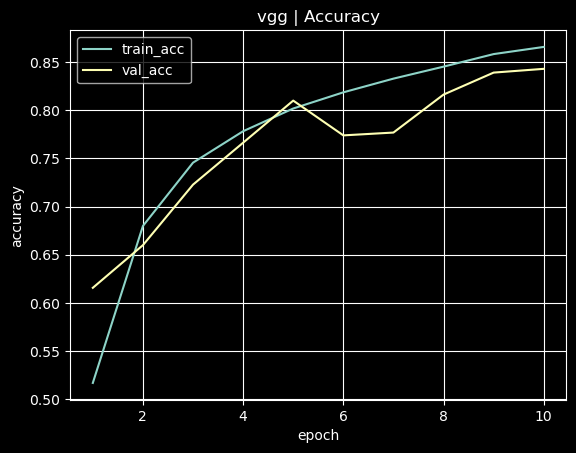

In [22]:
CFG.exp_name = "vgg"

vgg_model = MiniVGG(use_bn=True).to(device)

vgg_criterion = nn.CrossEntropyLoss()

vgg_optimizer = torch.optim.Adam(
    vgg_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

vgg_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    vgg_optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

vgg_run_dir = make_run_dir(CFG)

vgg_history = fit(
    vgg_model, train_loader, val_loader,
    vgg_optimizer, vgg_criterion, device,
    epochs=CFG.epochs, run_dir=vgg_run_dir, scheduler=vgg_scheduler
)

plot_history(vgg_history, title='vgg', run_dir=vgg_run_dir)

In [23]:
class DWSeparableConv(nn.Module):

    def __init__(self, in_ch, out_ch, stride=1, use_bn=True):
        super().__init__()

        self.dw = nn.Conv2d(
            in_ch, in_ch,
            kernel_size=3, padding=1, stride=stride,
            groups=in_ch,
            bias=not use_bn
        )
        self.dw_bn = nn.BatchNorm2d(in_ch) if use_bn else nn.Identity()
        self.dw_act = nn.ReLU(inplace=True)

        self.pw = nn.Conv2d(
            in_ch, out_ch,
            kernel_size=1, stride=1,
            bias=not use_bn
        )
        self.pw_bn = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
        self.pw_act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.dw(x)
        x = self.dw_bn(x)
        x = self.dw_act(x)

        x = self.pw(x)
        x = self.pw_bn(x)
        x = self.pw_act(x)
        return x


class MobileNetLite(nn.Module):

    def __init__(self, num_classes=10, use_bn=True):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, bias=not use_bn),
            nn.BatchNorm2d(32) if use_bn else nn.Identity(),
            nn.ReLU(inplace=True),
        )

        self.features = nn.Sequential(
            DWSeparableConv(32,  64,  stride=1, use_bn=use_bn),  
            DWSeparableConv(64,  128, stride=2, use_bn=use_bn),  
            DWSeparableConv(128, 128, stride=1, use_bn=use_bn),  
            DWSeparableConv(128, 256, stride=2, use_bn=use_bn),  
            DWSeparableConv(256, 256, stride=1, use_bn=use_bn)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)

        x = self.gap(x)      
        x = x.flatten(1)     
        logits = self.fc(x)  
        return logits


c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4971, train_acc=0.4497 | val_loss=1.2314, val_acc=0.5602 | lr=0.0010
Epoch 02/10 | train_loss=1.1149, train_acc=0.5995 | val_loss=1.0387, val_acc=0.6303 | lr=0.0010
Epoch 03/10 | train_loss=0.9511, train_acc=0.6604 | val_loss=0.9254, val_acc=0.6850 | lr=0.0010
Epoch 04/10 | train_loss=0.8399, train_acc=0.7041 | val_loss=0.8172, val_acc=0.7146 | lr=0.0010
Epoch 05/10 | train_loss=0.7603, train_acc=0.7346 | val_loss=0.7617, val_acc=0.7354 | lr=0.0010
Epoch 06/10 | train_loss=0.6960, train_acc=0.7567 | val_loss=0.7398, val_acc=0.7492 | lr=0.0010
Epoch 07/10 | train_loss=0.6420, train_acc=0.7777 | val_loss=0.6601, val_acc=0.7809 | lr=0.0010
Epoch 08/10 | train_loss=0.6052, train_acc=0.7870 | val_loss=0.7866, val_acc=0.7348 | lr=0.0010
Epoch 09/10 | train_loss=0.5690, train_acc=0.8012 | val_loss=0.6214, val_acc=0.7928 | lr=0.0010
Epoch 10/10 | train_loss=0.5410, train_acc=0.8104 | val_loss=0.6247, val_acc=0.7955 | lr=0.0010


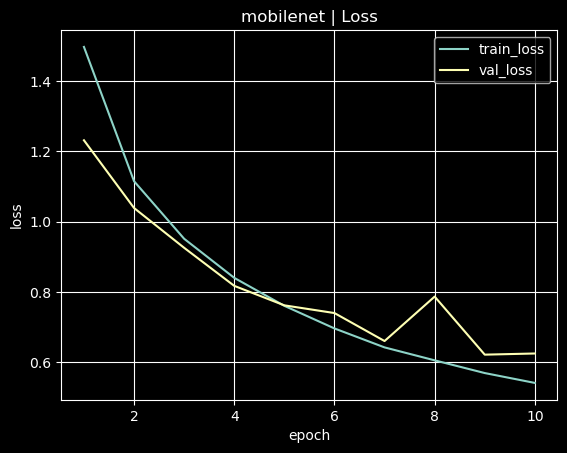

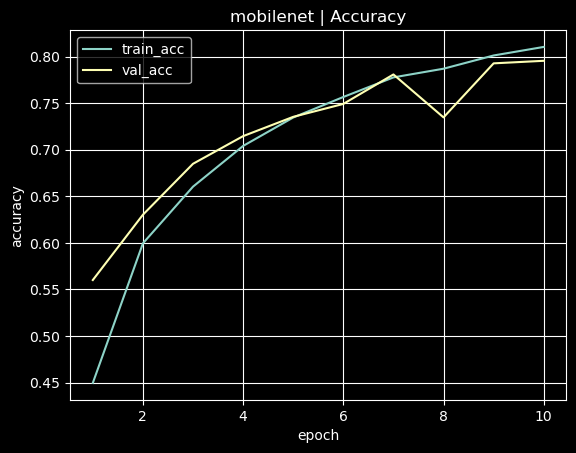

In [24]:
CFG.exp_name = "mobilenet_lite"

mobilenet_model = MobileNetLite(use_bn=True).to(device)

mobilenet_criterion = nn.CrossEntropyLoss()

mobilenet_optimizer = torch.optim.Adam(
    mobilenet_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

mobilenet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    mobilenet_optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

mobilenet_run_dir = make_run_dir(CFG)

mobilenet_history = fit(
    mobilenet_model, train_loader, val_loader,
    mobilenet_optimizer, mobilenet_criterion, device,
    epochs=CFG.epochs, run_dir=mobilenet_run_dir, scheduler=mobilenet_scheduler
)

plot_history(mobilenet_history, title='mobilenet', run_dir=mobilenet_run_dir)


## Эксперименты с слоями и гиперпараметрами ResNet

In [25]:
def get_activation(name):
    name = name.lower()
    if name == 'relu':
        return nn.ReLU(inplace=True)
    if name == 'leakyrelu':
        return nn.LeakyReLU(negative_slope=0.1, inplace=True)
    if name == 'silu':
        return nn.SiLU(inplace=True)
    if name == 'gelu':
        return nn.GELU()
    raise ValueError(f"Unknown activation: {name}")

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, stride=1, act_name="relu"):
        super().__init__()

        self.act1 = get_activation(act_name)
        self.act2 = get_activation(act_name)

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1,
                                stride=stride, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1,
                               stride=1, bias=not use_bn)
        self.bn2 = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()

        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + identity
        out = self.act2(out)

        return out
    

class ResNetLite(nn.Module):
    def __init__(self, num_classes=10, use_bn=True, width_mult=1.0, dropout=0, act_name='relu'):
        super().__init__()

        c1 = int(32 * width_mult)
        c2 = c1 * 2
        c3 = c1 * 4

        self.stem = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1, stride=1, bias=not use_bn),
            nn.BatchNorm2d(c1) if use_bn else nn.Identity(),
            get_activation(act_name)
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(c1, c1, use_bn=use_bn, stride=1),
            ResidualBlock(c1, c1, use_bn=use_bn, stride=1)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(c1, c2, use_bn=use_bn, stride=2),
            ResidualBlock(c2, c2, use_bn=use_bn, stride=1)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(c2, c3, use_bn=use_bn, stride=2),
            ResidualBlock(c3, c3, use_bn=use_bn, stride=1)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.drop = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
        self.fc = nn.Linear(c3, num_classes)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.gap(x)
        x = x.flatten(1)

        x = self.drop(x)
        logits = self.fc(x)

        return logits

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.3557, train_acc=0.5002 | val_loss=1.2029, val_acc=0.5709 | lr=0.0010
Epoch 02/10 | train_loss=0.9367, train_acc=0.6660 | val_loss=0.9693, val_acc=0.6727 | lr=0.0010
Epoch 03/10 | train_loss=0.7734, train_acc=0.7286 | val_loss=0.8013, val_acc=0.7236 | lr=0.0010
Epoch 04/10 | train_loss=0.6647, train_acc=0.7660 | val_loss=0.8456, val_acc=0.7305 | lr=0.0010
Epoch 05/10 | train_loss=0.5886, train_acc=0.7963 | val_loss=0.6697, val_acc=0.7836 | lr=0.0010
Epoch 06/10 | train_loss=0.5312, train_acc=0.8160 | val_loss=0.6015, val_acc=0.8020 | lr=0.0010
Epoch 07/10 | train_loss=0.4948, train_acc=0.8285 | val_loss=0.6140, val_acc=0.7986 | lr=0.0010
Epoch 08/10 | train_loss=0.4554, train_acc=0.8434 | val_loss=0.5730, val_acc=0.8139 | lr=0.0010
Epoch 09/10 | train_loss=0.4257, train_acc=0.8529 | val_loss=0.8290, val_acc=0.7512 | lr=0.0010
Epoch 10/10 | train_loss=0.4016, train_acc=0.8594 | val_loss=0.4961, val_acc=0.8383 | lr=0.0010


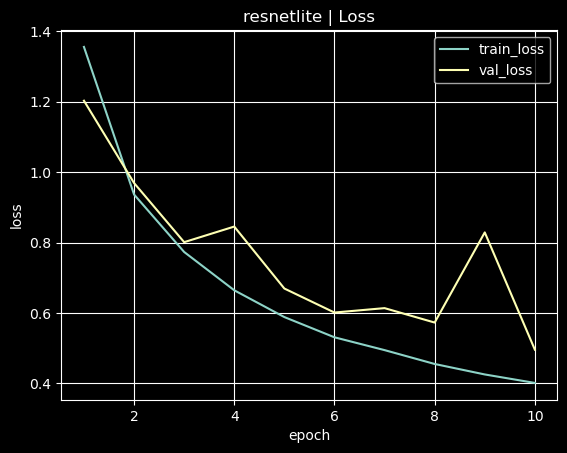

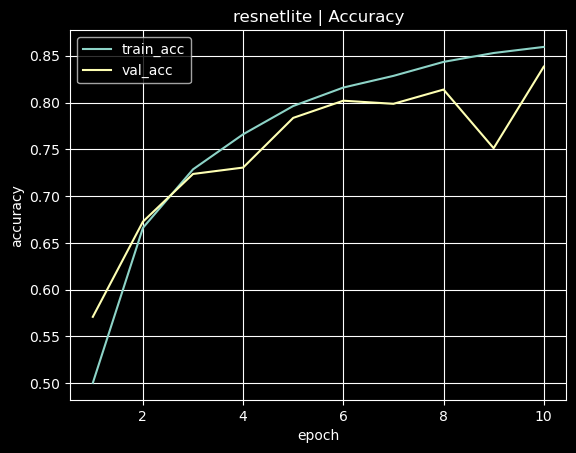

In [27]:
CFG.exp_name = "resnetlite_base"

resnetlite_model = ResNetLite(
    num_classes=10,
    use_bn=True,
    width_mult=1.0,
    dropout=0.0
).to(device)


resnetlite_criterion = nn.CrossEntropyLoss()

resnetlite_optimizer = torch.optim.Adam(
    resnetlite_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_run_dir = make_run_dir(CFG)

resnetlite_history = fit(
    resnetlite_model, train_loader, val_loader,
    resnetlite_optimizer, resnetlite_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_run_dir, scheduler=resnetlite_scheduler
)

plot_history(resnetlite_history, title='resnetlite', run_dir=resnetlite_run_dir)

### use_bn=False

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.7964, train_acc=0.3114 | val_loss=1.5280, val_acc=0.4238 | lr=0.0010
Epoch 02/10 | train_loss=1.3753, train_acc=0.4871 | val_loss=1.2376, val_acc=0.5398 | lr=0.0010
Epoch 03/10 | train_loss=1.1584, train_acc=0.5749 | val_loss=1.1166, val_acc=0.5893 | lr=0.0010
Epoch 04/10 | train_loss=1.0268, train_acc=0.6300 | val_loss=1.0000, val_acc=0.6490 | lr=0.0010
Epoch 05/10 | train_loss=0.9166, train_acc=0.6706 | val_loss=0.9491, val_acc=0.6705 | lr=0.0010
Epoch 06/10 | train_loss=0.8290, train_acc=0.7041 | val_loss=0.8769, val_acc=0.6975 | lr=0.0010
Epoch 07/10 | train_loss=0.7675, train_acc=0.7293 | val_loss=0.8274, val_acc=0.7141 | lr=0.0010
Epoch 08/10 | train_loss=0.7043, train_acc=0.7526 | val_loss=0.7692, val_acc=0.7387 | lr=0.0010
Epoch 09/10 | train_loss=0.6556, train_acc=0.7709 | val_loss=0.6836, val_acc=0.7732 | lr=0.0010
Epoch 10/10 | train_loss=0.6113, train_acc=0.7860 | val_loss=0.7078, val_acc=0.7719 | lr=0.0010


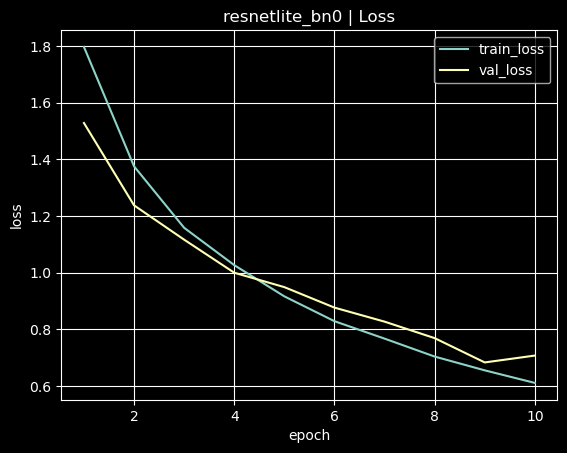

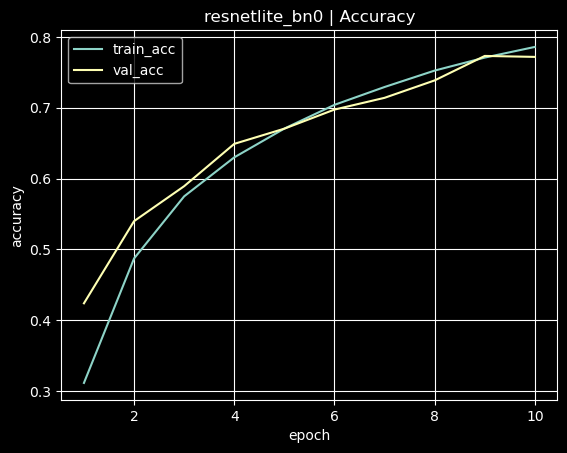

In [28]:
CFG.exp_name = "resnetlite_bn0"

resnetlite_bn0_model = ResNetLite(
    num_classes=10,
    use_bn=False,
    width_mult=1.0,
    dropout=0.0
).to(device)

resnetlite_bn0_criterion = nn.CrossEntropyLoss()
resnetlite_bn0_optimizer = torch.optim.Adam(
    resnetlite_bn0_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_bn0_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_bn0_optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

resnetlite_bn0_run_dir = make_run_dir(CFG)

resnetlite_bn0_history = fit(
    resnetlite_bn0_model, train_loader, val_loader,
    resnetlite_bn0_optimizer, resnetlite_bn0_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_bn0_run_dir, scheduler=resnetlite_bn0_scheduler
)

plot_history(resnetlite_bn0_history, title='resnetlite_bn0', run_dir=resnetlite_bn0_run_dir)


Оказывается, что BN может приводить к менее стабильному, но качественному обучению(0.83 > 0.8). Он выравнивает масштабы выходов, что ускоряет оптимизацию и делает поверхность для оптимизатора более приятной(так что Adam может делать более большие шаги). Увеличивается уверенность модели, что иногда приводит к скачкам loss-a

### Dropout=0.2

Dropout в голове должен:

- чуть снизить train_acc

- уменьшить train–val gap

- иногда поднять или стабилизировать val_acc, если был overfit

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4556, train_acc=0.4590 | val_loss=1.5531, val_acc=0.5002 | lr=0.0010
Epoch 02/10 | train_loss=1.0141, train_acc=0.6380 | val_loss=1.0327, val_acc=0.6457 | lr=0.0010
Epoch 03/10 | train_loss=0.8418, train_acc=0.7040 | val_loss=0.8162, val_acc=0.7262 | lr=0.0010
Epoch 04/10 | train_loss=0.7249, train_acc=0.7471 | val_loss=0.7892, val_acc=0.7428 | lr=0.0010
Epoch 05/10 | train_loss=0.6480, train_acc=0.7763 | val_loss=0.7247, val_acc=0.7521 | lr=0.0010
Epoch 06/10 | train_loss=0.5874, train_acc=0.7964 | val_loss=0.6167, val_acc=0.7959 | lr=0.0010
Epoch 07/10 | train_loss=0.5369, train_acc=0.8135 | val_loss=0.5680, val_acc=0.8133 | lr=0.0010
Epoch 08/10 | train_loss=0.5038, train_acc=0.8268 | val_loss=0.5501, val_acc=0.8180 | lr=0.0010
Epoch 09/10 | train_loss=0.4687, train_acc=0.8378 | val_loss=0.5948, val_acc=0.8092 | lr=0.0010
Epoch 10/10 | train_loss=0.4425, train_acc=0.8473 | val_loss=0.5084, val_acc=0.8301 | lr=0.0010


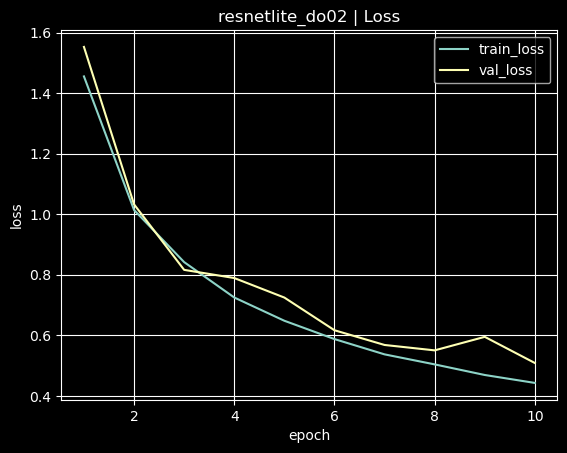

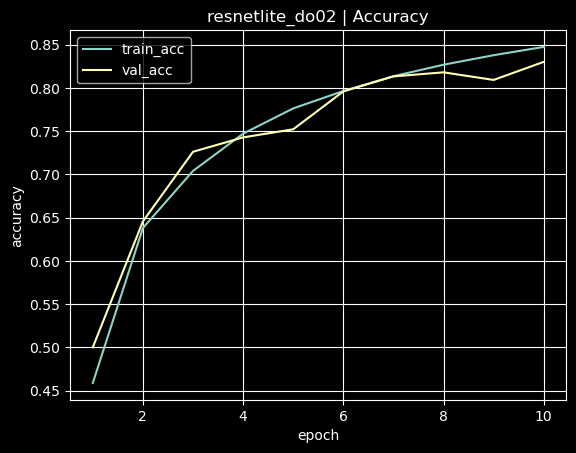

In [29]:
CFG.exp_name = "resnetlite_do02"

resnetlite_do02_model = ResNetLite(
    num_classes=10,
    use_bn=True,
    width_mult=1.0,
    dropout=0.2
).to(device)

resnetlite_do02_criterion = nn.CrossEntropyLoss()

resnetlite_do02_optimizer = torch.optim.Adam(
    resnetlite_do02_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_do02_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_do02_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_do02_run_dir = make_run_dir(CFG)

resnetlite_do02_history = fit(
    resnetlite_do02_model, train_loader, val_loader,
    resnetlite_do02_optimizer, resnetlite_do02_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_do02_run_dir,
    scheduler=resnetlite_do02_scheduler
)

plot_history(resnetlite_do02_history, title='resnetlite_do02', run_dir=resnetlite_do02_run_dir)


val_acc > train_acc особенно заметно на первой эпохе

Обучение оказалось более стабильным, чем просто с BN, кроме того val_acc достиг наибольщего значения среди трёх эксперементальных моделей

## Изменяем количество выходных каналов внутри сети

#### width_mult=0.5

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.5394, train_acc=0.4288 | val_loss=1.2646, val_acc=0.5434 | lr=0.0010
Epoch 02/10 | train_loss=1.1179, train_acc=0.6002 | val_loss=1.0423, val_acc=0.6312 | lr=0.0010
Epoch 03/10 | train_loss=0.9712, train_acc=0.6563 | val_loss=0.9635, val_acc=0.6617 | lr=0.0010
Epoch 04/10 | train_loss=0.8736, train_acc=0.6931 | val_loss=0.8719, val_acc=0.6990 | lr=0.0010
Epoch 05/10 | train_loss=0.7962, train_acc=0.7226 | val_loss=0.8966, val_acc=0.7035 | lr=0.0010
Epoch 06/10 | train_loss=0.7351, train_acc=0.7442 | val_loss=0.7526, val_acc=0.7410 | lr=0.0010
Epoch 07/10 | train_loss=0.6851, train_acc=0.7626 | val_loss=0.7590, val_acc=0.7525 | lr=0.0010
Epoch 08/10 | train_loss=0.6465, train_acc=0.7771 | val_loss=0.7774, val_acc=0.7486 | lr=0.0010
Epoch 09/10 | train_loss=0.6170, train_acc=0.7884 | val_loss=0.6659, val_acc=0.7760 | lr=0.0010
Epoch 10/10 | train_loss=0.5867, train_acc=0.7999 | val_loss=0.6874, val_acc=0.7768 | lr=0.0010


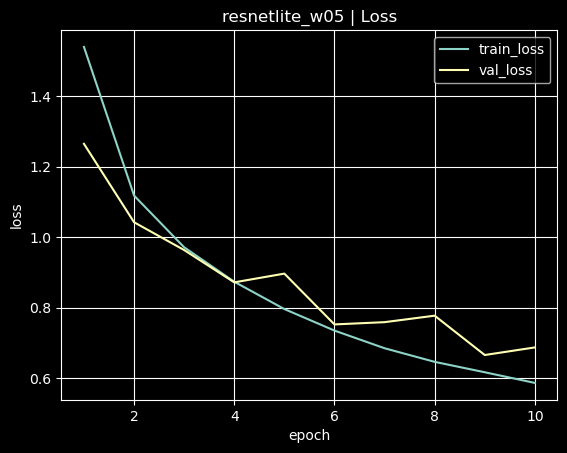

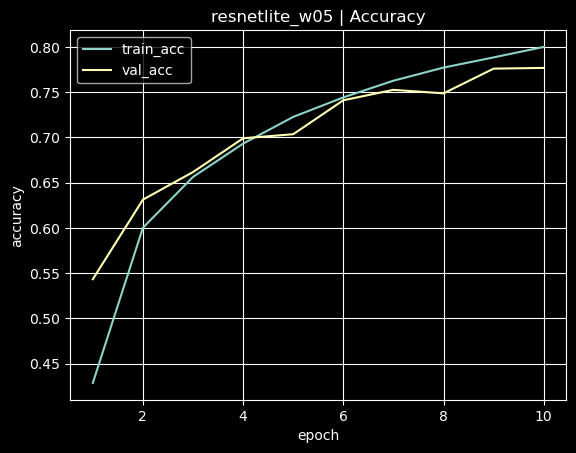

In [30]:
CFG.exp_name = 'resnetlite_w05_do02'

resnetlite_w05_model = ResNetLite(
    num_classes=10,
    use_bn=True,
    width_mult=0.5,
    dropout=0.2
).to(device)

resnetlite_w05_criterion = nn.CrossEntropyLoss()

resnetlite_w05_optimizer = torch.optim.Adam(
    resnetlite_w05_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_w05_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_w05_optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_w05_run_dir = make_run_dir(CFG)
resnetlite_w05_history = fit(
    resnetlite_w05_model, train_loader, val_loader,
    resnetlite_w05_optimizer, resnetlite_w05_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_w05_run_dir,
    scheduler=resnetlite_w05_scheduler
)

plot_history(resnetlite_w05_history, title='resnetlite_w05', run_dir=resnetlite_w05_run_dir)

Качество упало (best val_acc ≈ 0.7807), но обучение очень ровное
width_mult=0.5 сильно режет число каналов, но также из-за меньше сложностт оптимизация становится проще. Кроме того, получается маленький gap, то есть модель не переобучается и скорее недообучается.

#### width_mult=1.5

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4359, train_acc=0.4696 | val_loss=1.2142, val_acc=0.5687 | lr=0.0010
Epoch 02/10 | train_loss=0.9838, train_acc=0.6483 | val_loss=0.9233, val_acc=0.6801 | lr=0.0010
Epoch 03/10 | train_loss=0.7956, train_acc=0.7190 | val_loss=0.8459, val_acc=0.7133 | lr=0.0010
Epoch 04/10 | train_loss=0.6772, train_acc=0.7644 | val_loss=0.7773, val_acc=0.7436 | lr=0.0010
Epoch 05/10 | train_loss=0.5872, train_acc=0.7963 | val_loss=0.8453, val_acc=0.7432 | lr=0.0010
Epoch 06/10 | train_loss=0.5294, train_acc=0.8176 | val_loss=0.7215, val_acc=0.7750 | lr=0.0010
Epoch 07/10 | train_loss=0.4801, train_acc=0.8347 | val_loss=0.5355, val_acc=0.8193 | lr=0.0010
Epoch 08/10 | train_loss=0.4437, train_acc=0.8459 | val_loss=0.5865, val_acc=0.8080 | lr=0.0010
Epoch 09/10 | train_loss=0.4073, train_acc=0.8598 | val_loss=0.5714, val_acc=0.8141 | lr=0.0010
Epoch 10/10 | train_loss=0.3785, train_acc=0.8689 | val_loss=0.4789, val_acc=0.8426 | lr=0.0010


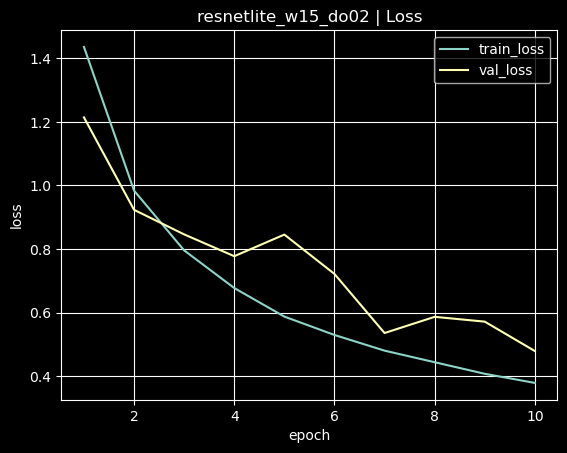

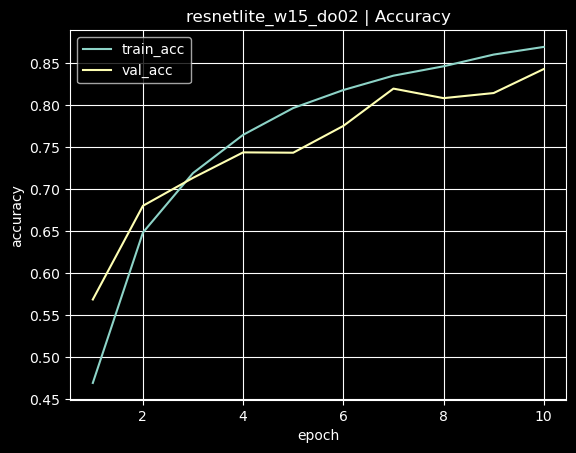

In [31]:
CFG.exp_name = "resnetlite_w15_do02"

resnetlite_w15_model = ResNetLite(
    num_classes=10,
    use_bn=True,
    width_mult=1.5,
    dropout=0.2
).to(device)

resnetlite_w15_criterion = nn.CrossEntropyLoss()

resnetlite_w15_optimizer = torch.optim.Adam(
    resnetlite_w15_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_w15_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_w15_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_w15_run_dir = make_run_dir(CFG)

resnetlite_w15_history = fit(
    resnetlite_w15_model, train_loader, val_loader,
    resnetlite_w15_optimizer, resnetlite_w15_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_w15_run_dir,
    scheduler=resnetlite_w15_scheduler
)

plot_history(resnetlite_w15_history, title=CFG.exp_name, run_dir=resnetlite_w15_run_dir)

Модель показала несколько лучшие результаты, но менее стабильное обучение

### Изменяем функцию активации

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4090, train_acc=0.4807 | val_loss=1.1883, val_acc=0.5850 | lr=0.0010
Epoch 02/10 | train_loss=0.9601, train_acc=0.6567 | val_loss=1.0509, val_acc=0.6498 | lr=0.0010
Epoch 03/10 | train_loss=0.7875, train_acc=0.7229 | val_loss=1.0232, val_acc=0.6805 | lr=0.0010
Epoch 04/10 | train_loss=0.6639, train_acc=0.7671 | val_loss=0.7913, val_acc=0.7451 | lr=0.0010
Epoch 05/10 | train_loss=0.5878, train_acc=0.7962 | val_loss=0.5983, val_acc=0.8020 | lr=0.0010
Epoch 06/10 | train_loss=0.5277, train_acc=0.8164 | val_loss=0.5666, val_acc=0.8125 | lr=0.0010
Epoch 07/10 | train_loss=0.4766, train_acc=0.8371 | val_loss=0.5869, val_acc=0.8152 | lr=0.0010
Epoch 08/10 | train_loss=0.4419, train_acc=0.8471 | val_loss=0.5952, val_acc=0.8098 | lr=0.0010
Epoch 09/10 | train_loss=0.4041, train_acc=0.8609 | val_loss=0.5182, val_acc=0.8355 | lr=0.0010
Epoch 10/10 | train_loss=0.3776, train_acc=0.8693 | val_loss=0.4616, val_acc=0.8467 | lr=0.0010


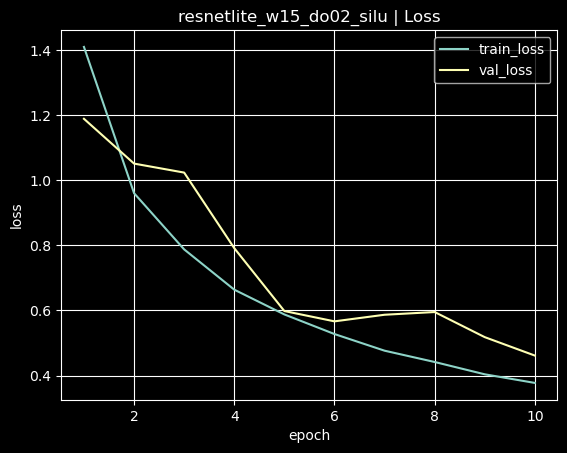

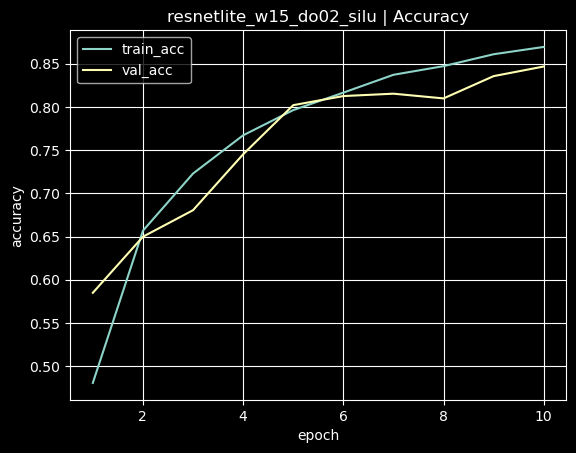

In [32]:
CFG.exp_name = 'resnetlite_w15_do02_silu'

resnetlite_w15_do02_silu_model = ResNetLite(
    use_bn=True,
    width_mult=1.5,
    dropout=0.2,
    act_name='silu'
).to(device)

resnetlite_w15_do02_silu_criterion = nn.CrossEntropyLoss()

resnetlite_w15_do02_silu_optimizer = torch.optim.Adam(
    resnetlite_w15_do02_silu_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_w15_do02_silu_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_w15_do02_silu_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_w15_do02_silu_run_dir = make_run_dir(CFG)

resnetlite_w15_do02_silu_history = fit(
    resnetlite_w15_do02_silu_model, train_loader, val_loader,
    resnetlite_w15_do02_silu_optimizer, resnetlite_w15_do02_silu_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_w15_do02_silu_run_dir,
    scheduler=resnetlite_w15_do02_silu_scheduler
)

plot_history(resnetlite_w15_do02_silu_history, title=CFG.exp_name, run_dir=resnetlite_w15_do02_silu_run_dir)

Заметно вырос gap между train и val(train стал значительно больше), acc особо не изменился

### LeakyReLU

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4356, train_acc=0.4694 | val_loss=1.3958, val_acc=0.5203 | lr=0.0010
Epoch 02/10 | train_loss=0.9740, train_acc=0.6517 | val_loss=0.9203, val_acc=0.6805 | lr=0.0010
Epoch 03/10 | train_loss=0.7792, train_acc=0.7273 | val_loss=1.1137, val_acc=0.6521 | lr=0.0010
Epoch 04/10 | train_loss=0.6621, train_acc=0.7697 | val_loss=0.8745, val_acc=0.7199 | lr=0.0010
Epoch 05/10 | train_loss=0.5703, train_acc=0.8028 | val_loss=0.6495, val_acc=0.7770 | lr=0.0010
Epoch 06/10 | train_loss=0.5149, train_acc=0.8222 | val_loss=0.6231, val_acc=0.7967 | lr=0.0010
Epoch 07/10 | train_loss=0.4701, train_acc=0.8376 | val_loss=0.5965, val_acc=0.8018 | lr=0.0010
Epoch 08/10 | train_loss=0.4308, train_acc=0.8527 | val_loss=0.5285, val_acc=0.8242 | lr=0.0010
Epoch 09/10 | train_loss=0.4024, train_acc=0.8626 | val_loss=0.5458, val_acc=0.8203 | lr=0.0010
Epoch 10/10 | train_loss=0.3724, train_acc=0.8720 | val_loss=0.4642, val_acc=0.8484 | lr=0.0010


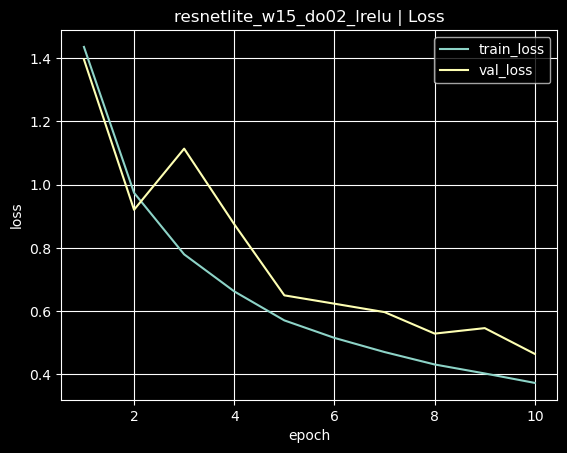

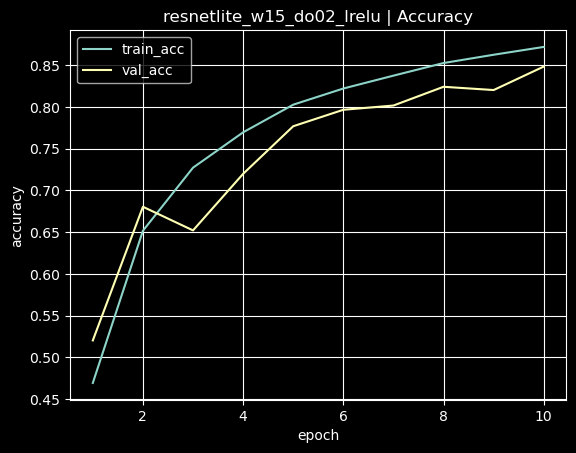

In [33]:
CFG.exp_name = "resnetlite_w15_do02_lrelu"

resnetlite_w15_do02_lrelu_model = ResNetLite(
    use_bn=True,
    width_mult=1.5,
    dropout=0.2,
    act_name="leakyrelu"
).to(device)

resnetlite_w15_do02_lrelu_criterion = nn.CrossEntropyLoss()

resnetlite_w15_do02_lrelu_optimizer = torch.optim.Adam(
    resnetlite_w15_do02_lrelu_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_w15_do02_lrelu_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_w15_do02_lrelu_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_w15_do02_lrelu_run_dir = make_run_dir(CFG)

resnetlite_w15_do02_lrelu_history = fit(
    resnetlite_w15_do02_lrelu_model, train_loader, val_loader,
    resnetlite_w15_do02_lrelu_optimizer, resnetlite_w15_do02_lrelu_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_w15_do02_lrelu_run_dir,
    scheduler=resnetlite_w15_do02_lrelu_scheduler
)

plot_history(resnetlite_w15_do02_lrelu_history, title=CFG.exp_name, run_dir=resnetlite_w15_do02_lrelu_run_dir)

LeakyReLU показал себя хуже других активаций: acc уменьшился, но после 5-ой эпохи обучение стабилизировалось

Поставим dropout=0.3, чтобы уменьшить gap и проверить, был ли скрытый overfit или underfit

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4582, train_acc=0.4593 | val_loss=1.7755, val_acc=0.4365 | lr=0.0010
Epoch 02/10 | train_loss=1.0076, train_acc=0.6393 | val_loss=1.2541, val_acc=0.6008 | lr=0.0010
Epoch 03/10 | train_loss=0.8286, train_acc=0.7060 | val_loss=1.0621, val_acc=0.6633 | lr=0.0010
Epoch 04/10 | train_loss=0.7072, train_acc=0.7542 | val_loss=0.8329, val_acc=0.7320 | lr=0.0010
Epoch 05/10 | train_loss=0.6147, train_acc=0.7885 | val_loss=0.7166, val_acc=0.7643 | lr=0.0010
Epoch 06/10 | train_loss=0.5465, train_acc=0.8108 | val_loss=0.6311, val_acc=0.7834 | lr=0.0010
Epoch 07/10 | train_loss=0.4983, train_acc=0.8279 | val_loss=0.6151, val_acc=0.8023 | lr=0.0010
Epoch 08/10 | train_loss=0.4609, train_acc=0.8417 | val_loss=0.6742, val_acc=0.7865 | lr=0.0010
Epoch 09/10 | train_loss=0.4191, train_acc=0.8578 | val_loss=0.6986, val_acc=0.7859 | lr=0.0010
Epoch 10/10 | train_loss=0.3939, train_acc=0.8640 | val_loss=0.4694, val_acc=0.8494 | lr=0.0010


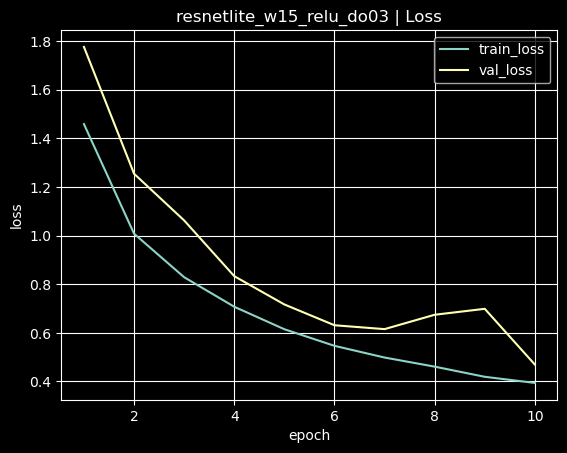

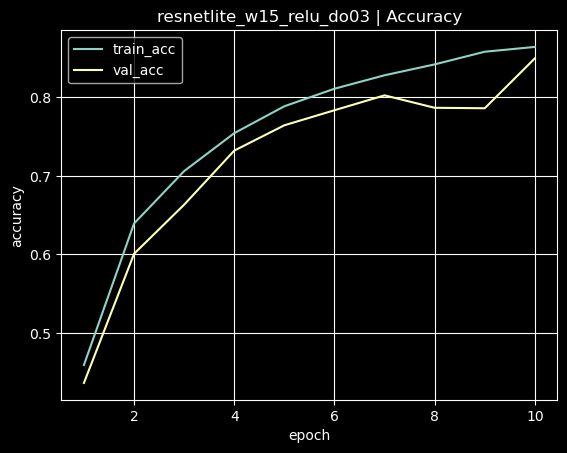

In [34]:
CFG.exp_name = "resnetlite_w15_relu_do03"

resnetlite_w15_relu_do03_model = ResNetLite(
    use_bn=True,
    width_mult=1.5,
    dropout=0.3,
    act_name="relu"
).to(device)

resnetlite_w15_relu_do03_criterion = nn.CrossEntropyLoss()

resnetlite_w15_relu_do03_optimizer = torch.optim.Adam(
    resnetlite_w15_relu_do03_model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

resnetlite_w15_relu_do03_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnetlite_w15_relu_do03_optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

resnetlite_w15_relu_do03_run_dir = make_run_dir(CFG)

resnetlite_w15_relu_do03_history = fit(
    resnetlite_w15_relu_do03_model, train_loader, val_loader,
    resnetlite_w15_relu_do03_optimizer, resnetlite_w15_relu_do03_criterion, device,
    epochs=CFG.epochs, run_dir=resnetlite_w15_relu_do03_run_dir,
    scheduler=resnetlite_w15_relu_do03_scheduler
)

plot_history(resnetlite_w15_relu_do03_history, title=CFG.exp_name, run_dir=resnetlite_w15_relu_do03_run_dir)

val_acc упал сильно, а gap уменьшился чуть-чуть, то есть dropout=0.3 сделал регуляризацию сильнее, но переусердствовал и качество упало

### weight_decay

Попробуем уменьшить dropout и поиграться с weight_decay

In [35]:
def run_resnetlite_experiment(exp_name, wd, seed):
    CFG.exp_name = exp_name
    CFG.seed = seed
    model = ResNetLite(
        use_bn=True,
        width_mult=1.5,
        dropout=0.1,
        act_name="relu"
    ).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CFG.lr,
        weight_decay=wd
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2, verbose=True
    )

    run_dir = make_run_dir(CFG)

    history = fit(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        epochs=CFG.epochs, run_dir=run_dir,
        scheduler=scheduler
    )

    plot_history(history, title=exp_name, run_dir=run_dir)
    best_val = max(history["val_acc"])
    return best_val, history


c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4238, train_acc=0.4753 | val_loss=1.5733, val_acc=0.5199 | lr=0.0010
Epoch 02/10 | train_loss=0.9690, train_acc=0.6544 | val_loss=1.2172, val_acc=0.6123 | lr=0.0010
Epoch 03/10 | train_loss=0.7721, train_acc=0.7257 | val_loss=0.8415, val_acc=0.7156 | lr=0.0010
Epoch 04/10 | train_loss=0.6487, train_acc=0.7722 | val_loss=0.9006, val_acc=0.7205 | lr=0.0010
Epoch 05/10 | train_loss=0.5798, train_acc=0.7991 | val_loss=0.6443, val_acc=0.7852 | lr=0.0010
Epoch 06/10 | train_loss=0.5145, train_acc=0.8230 | val_loss=0.7136, val_acc=0.7865 | lr=0.0010
Epoch 07/10 | train_loss=0.4690, train_acc=0.8392 | val_loss=0.5666, val_acc=0.8123 | lr=0.0010
Epoch 08/10 | train_loss=0.4288, train_acc=0.8522 | val_loss=0.6273, val_acc=0.7951 | lr=0.0010
Epoch 09/10 | train_loss=0.3998, train_acc=0.8613 | val_loss=0.5187, val_acc=0.8387 | lr=0.0010
Epoch 10/10 | train_loss=0.3702, train_acc=0.8708 | val_loss=0.4975, val_acc=0.8404 | lr=0.0010


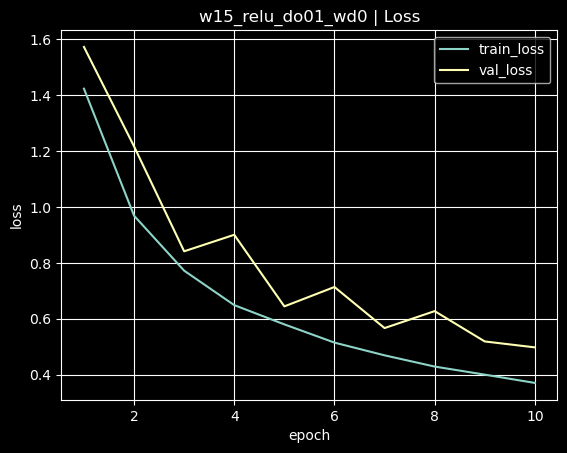

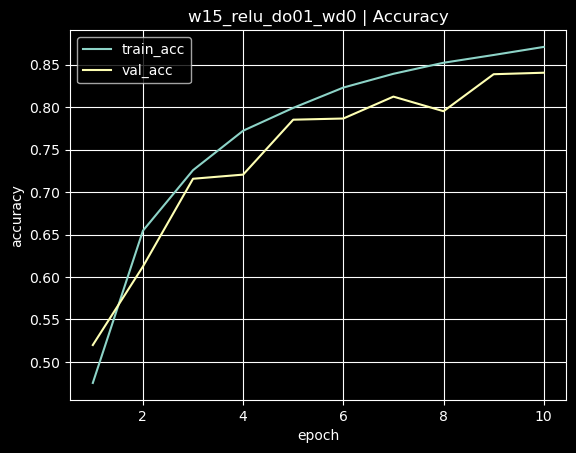

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4176, train_acc=0.4787 | val_loss=1.2617, val_acc=0.5600 | lr=0.0010
Epoch 02/10 | train_loss=0.9748, train_acc=0.6482 | val_loss=0.9732, val_acc=0.6686 | lr=0.0010
Epoch 03/10 | train_loss=0.8026, train_acc=0.7162 | val_loss=0.8824, val_acc=0.7066 | lr=0.0010
Epoch 04/10 | train_loss=0.6797, train_acc=0.7633 | val_loss=0.7984, val_acc=0.7400 | lr=0.0010
Epoch 05/10 | train_loss=0.5982, train_acc=0.7921 | val_loss=0.7314, val_acc=0.7652 | lr=0.0010
Epoch 06/10 | train_loss=0.5439, train_acc=0.8138 | val_loss=0.7015, val_acc=0.7785 | lr=0.0010
Epoch 07/10 | train_loss=0.4982, train_acc=0.8273 | val_loss=0.6984, val_acc=0.7863 | lr=0.0010
Epoch 08/10 | train_loss=0.4633, train_acc=0.8397 | val_loss=0.5659, val_acc=0.8209 | lr=0.0010
Epoch 09/10 | train_loss=0.4307, train_acc=0.8519 | val_loss=0.5431, val_acc=0.8209 | lr=0.0010
Epoch 10/10 | train_loss=0.4057, train_acc=0.8600 | val_loss=0.6028, val_acc=0.8043 | lr=0.0010


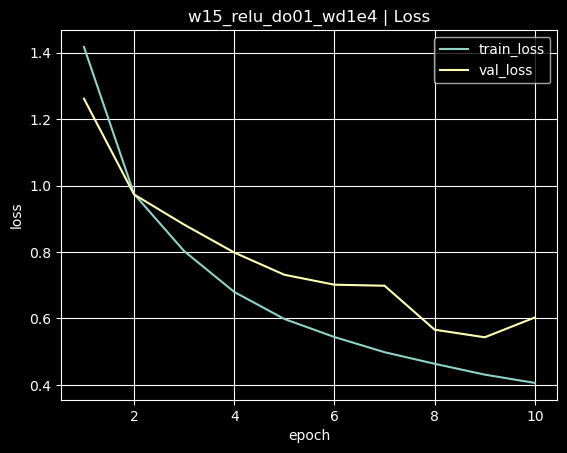

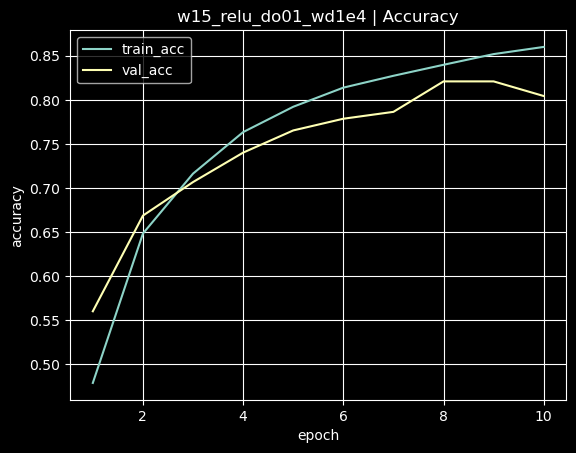

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4439, train_acc=0.4655 | val_loss=1.7992, val_acc=0.4453 | lr=0.0010
Epoch 02/10 | train_loss=1.0236, train_acc=0.6368 | val_loss=1.3556, val_acc=0.5543 | lr=0.0010
Epoch 03/10 | train_loss=0.8649, train_acc=0.6968 | val_loss=0.9294, val_acc=0.6785 | lr=0.0010
Epoch 04/10 | train_loss=0.7493, train_acc=0.7380 | val_loss=1.8270, val_acc=0.5072 | lr=0.0010
Epoch 05/10 | train_loss=0.6541, train_acc=0.7734 | val_loss=0.8292, val_acc=0.7164 | lr=0.0010


KeyboardInterrupt: 

In [36]:
best0, h0 = run_resnetlite_experiment("w15_relu_do01_wd0",   wd=0.0, seed=CFG.seed)
best1, h1 = run_resnetlite_experiment("w15_relu_do01_wd1e4", wd=1e-4, seed=CFG.seed)
best5, h5 = run_resnetlite_experiment("w15_relu_do01_wd5e4", wd=5e-4, seed=CFG.seed)

print("best val_acc:",
      "wd0", best0,
      "wd1e-4", best1,
      "wd5e-4", best5)

weight_decay здесь сильно мешает: он делает регуляризацию слишком сильной (в сумме с dropout=0.1), и модель недоучивается.

Раз мы нашли новый чемпион (0.8525), логично проверить: это “удачный сид” или реально лучше.

### Меняем seed

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.4483, train_acc=0.4657 | val_loss=1.1639, val_acc=0.5885 | lr=0.0010
Epoch 02/10 | train_loss=1.0029, train_acc=0.6383 | val_loss=1.2498, val_acc=0.5980 | lr=0.0010
Epoch 03/10 | train_loss=0.8141, train_acc=0.7098 | val_loss=0.9516, val_acc=0.6889 | lr=0.0010
Epoch 04/10 | train_loss=0.6830, train_acc=0.7620 | val_loss=0.7396, val_acc=0.7428 | lr=0.0010
Epoch 05/10 | train_loss=0.5994, train_acc=0.7936 | val_loss=0.6895, val_acc=0.7807 | lr=0.0010
Epoch 06/10 | train_loss=0.5297, train_acc=0.8152 | val_loss=0.5931, val_acc=0.8090 | lr=0.0010
Epoch 07/10 | train_loss=0.4834, train_acc=0.8324 | val_loss=0.5831, val_acc=0.8131 | lr=0.0010
Epoch 08/10 | train_loss=0.4412, train_acc=0.8473 | val_loss=0.5410, val_acc=0.8189 | lr=0.0010
Epoch 09/10 | train_loss=0.4040, train_acc=0.8606 | val_loss=0.5919, val_acc=0.8105 | lr=0.0010
Epoch 10/10 | train_loss=0.3809, train_acc=0.8683 | val_loss=0.5044, val_acc=0.8334 | lr=0.0010


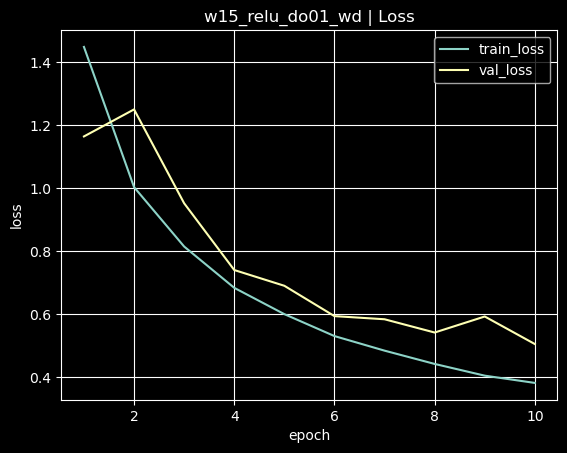

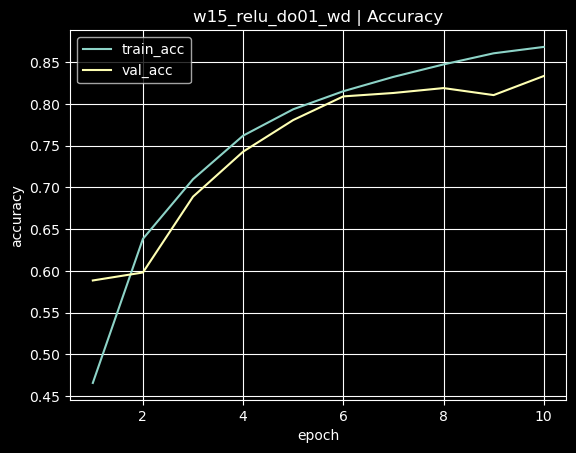

In [37]:
changed_seed_best0, changed_seed_model_h0 = run_resnetlite_experiment("w15_relu_do01_wd", wd=0, seed=CFG.seed+1)

Похоже, это был просто удачный seed

## Fine-tuning 

Будем использовать ResNet18 с предобученными весами

Но сначала нужно выполнить нормализацию данных под ImageNet

In [45]:
pre_tfms = ResNet18_Weights.DEFAULT.transforms()

train_full_pre = datasets.ImageFolder(root=str(TRAIN_DIR), transform=pre_tfms)

train_ds_pre = Subset(train_full_pre, train_subset_aug.indices)
val_ds_pre = Subset(train_full_pre, val_subset_indices.indices)

train_loader_pre = DataLoader(
    train_ds_pre, 
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader_pre = DataLoader(
    val_ds_pre, 
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

### Linear probe

In [46]:
weights = ResNet18_Weights.DEFAULT
pre_tfms = weights.transforms()
backbone = resnet18(weights=weights)

num_classes = 10
in_features = backbone.fc.in_features
backbone.fc = nn.Linear(in_features, num_classes)

for name, param in backbone.named_parameters():
    param.requires_grad = False

for param in backbone.fc.parameters():
    param.requires_grad = True

pre_linear_model = backbone.to(device)

pre_linear_criterion = nn.CrossEntropyLoss()

pre_linear_optimizer = torch.optim.Adam(
    pre_linear_model.fc.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

pre_linear_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    pre_linear_optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=1.0106, train_acc=0.6795 | val_loss=0.7640, val_acc=0.7465 | lr=0.0010
Epoch 02/10 | train_loss=0.7116, train_acc=0.7589 | val_loss=0.7128, val_acc=0.7596 | lr=0.0010
Epoch 03/10 | train_loss=0.6669, train_acc=0.7713 | val_loss=0.6848, val_acc=0.7596 | lr=0.0010
Epoch 04/10 | train_loss=0.6459, train_acc=0.7776 | val_loss=0.6750, val_acc=0.7645 | lr=0.0010
Epoch 05/10 | train_loss=0.6308, train_acc=0.7829 | val_loss=0.6571, val_acc=0.7734 | lr=0.0010
Epoch 06/10 | train_loss=0.6196, train_acc=0.7845 | val_loss=0.6507, val_acc=0.7785 | lr=0.0010
Epoch 07/10 | train_loss=0.6162, train_acc=0.7845 | val_loss=0.6685, val_acc=0.7730 | lr=0.0010
Epoch 08/10 | train_loss=0.6114, train_acc=0.7864 | val_loss=0.6573, val_acc=0.7777 | lr=0.0010
Epoch 09/10 | train_loss=0.6033, train_acc=0.7900 | val_loss=0.6450, val_acc=0.7797 | lr=0.0010
Epoch 10/10 | train_loss=0.6003, train_acc=0.7921 | val_loss=0.6500, val_acc=0.7758 | lr=0.0010


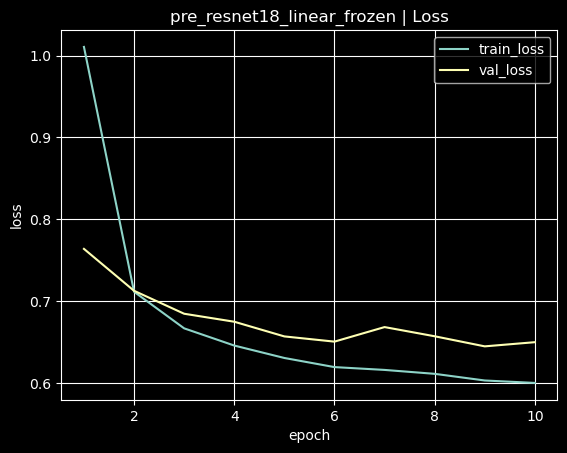

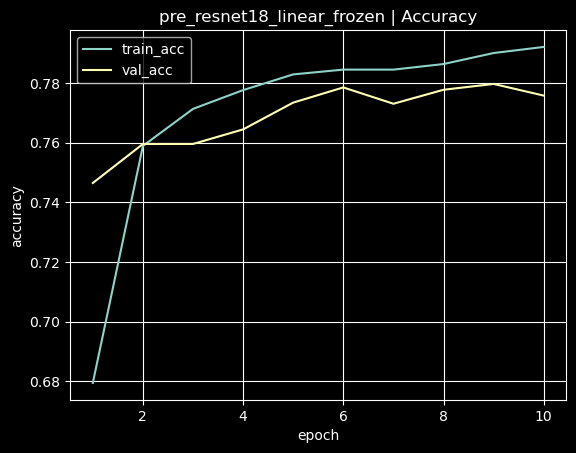

In [47]:
CFG.exp_name = 'pre_resnet18_linear_frozen'
pre_linear_run_dir = make_run_dir(CFG)

pre_linear_history = fit(
    pre_linear_model, train_loader_pre, val_loader_pre,
    pre_linear_optimizer, pre_linear_criterion, device,
    epochs=CFG.epochs, run_dir=pre_linear_run_dir,
    scheduler=pre_linear_scheduler
)

plot_history(pre_linear_history, title=CFG.exp_name, run_dir=pre_linear_run_dir)

Обучение одного fc слоя с претренированными backbone слоями привело к значительному росту качества предсказаний на первых слоях, однако сразу же застопорилось. 


Возможно, обучения одного линейного fc слоя недостаточно, ведь созданные ранее модели показали более хорошие результаты, при этом будучи менее сложными

### MLP голова

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=0.8385, train_acc=0.7122 | val_loss=0.7152, val_acc=0.7541 | lr=0.0010
Epoch 02/10 | train_loss=0.6766, train_acc=0.7646 | val_loss=0.6720, val_acc=0.7615 | lr=0.0010
Epoch 03/10 | train_loss=0.6398, train_acc=0.7772 | val_loss=0.6554, val_acc=0.7754 | lr=0.0010
Epoch 04/10 | train_loss=0.6166, train_acc=0.7837 | val_loss=0.6743, val_acc=0.7627 | lr=0.0010
Epoch 05/10 | train_loss=0.5918, train_acc=0.7922 | val_loss=0.6312, val_acc=0.7832 | lr=0.0010
Epoch 06/10 | train_loss=0.5726, train_acc=0.7993 | val_loss=0.6214, val_acc=0.7881 | lr=0.0010
Epoch 07/10 | train_loss=0.5579, train_acc=0.8028 | val_loss=0.6102, val_acc=0.7875 | lr=0.0010
Epoch 08/10 | train_loss=0.5333, train_acc=0.8120 | val_loss=0.6263, val_acc=0.7816 | lr=0.0010
Epoch 09/10 | train_loss=0.5143, train_acc=0.8182 | val_loss=0.6305, val_acc=0.7869 | lr=0.0010
Epoch 10/10 | train_loss=0.4933, train_acc=0.8252 | val_loss=0.5909, val_acc=0.7973 | lr=0.0010


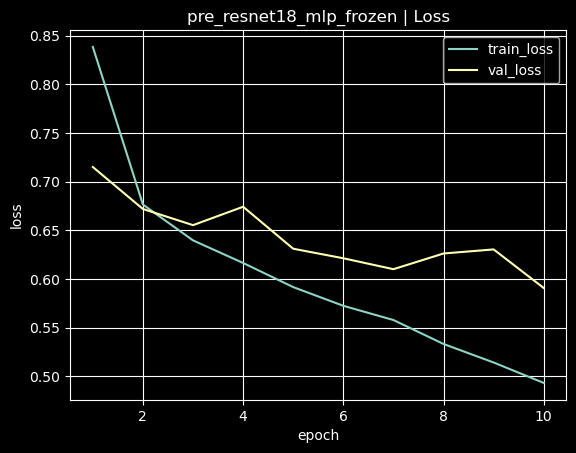

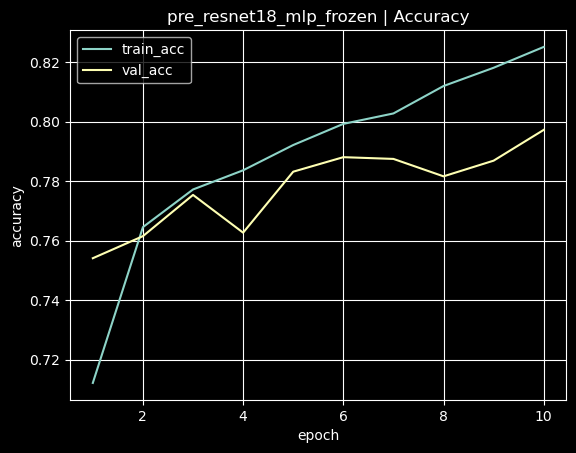

In [49]:
backbone.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)
)

pre_mlp_model = backbone.to(device)

pre_mlp_criterion = nn.CrossEntropyLoss()

pre_mlp_optimizer = torch.optim.Adam(
    pre_mlp_model.fc.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay
)

pre_mlp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    pre_mlp_optimizer,
    mode='min',
    factor=0.5, 
    patience=2, 
    verbose=True
)

CFG.exp_name = 'pre_resnet18_mlp_frozen'
pre_mlp_run_dir = make_run_dir(CFG)

pre_mlp_history = fit(
    pre_mlp_model, train_loader_pre, val_loader_pre,
    pre_mlp_optimizer, pre_mlp_criterion, device,
    epochs=CFG.epochs, run_dir=pre_mlp_run_dir,
    scheduler=pre_mlp_scheduler
)

plot_history(pre_mlp_history, title=CFG.exp_name, run_dir=pre_mlp_run_dir)

MLP head дал прирост 1.5–2%, значит проблема реально была в слишком простой голове

### Частичный fine-tune

Проверим, фичи нужно адаптировать под CIFAR или head уже достаточно

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=0.5082, train_acc=0.8260 | val_loss=0.3845, val_acc=0.8650 | lr=0.0001
Epoch 02/10 | train_loss=0.1702, train_acc=0.9400 | val_loss=0.3579, val_acc=0.8854 | lr=0.0001
Epoch 03/10 | train_loss=0.0562, train_acc=0.9811 | val_loss=0.4587, val_acc=0.8902 | lr=0.0001
Epoch 04/10 | train_loss=0.0342, train_acc=0.9884 | val_loss=0.5201, val_acc=0.8820 | lr=0.0001
Epoch 05/10 | train_loss=0.0293, train_acc=0.9900 | val_loss=0.5243, val_acc=0.8818 | lr=0.0001
Epoch 06/10 | train_loss=0.0112, train_acc=0.9966 | val_loss=0.4743, val_acc=0.9037 | lr=0.0001
Epoch 07/10 | train_loss=0.0030, train_acc=0.9994 | val_loss=0.5098, val_acc=0.8955 | lr=0.0001
Epoch 08/10 | train_loss=0.0025, train_acc=0.9993 | val_loss=0.5482, val_acc=0.9000 | lr=0.0000
Epoch 09/10 | train_loss=0.0014, train_acc=0.9997 | val_loss=0.5135, val_acc=0.9043 | lr=0.0000
Epoch 10/10 | train_loss=0.0008, train_acc=0.9998 | val_loss=0.5296, val_acc=0.9002 | lr=0.0000


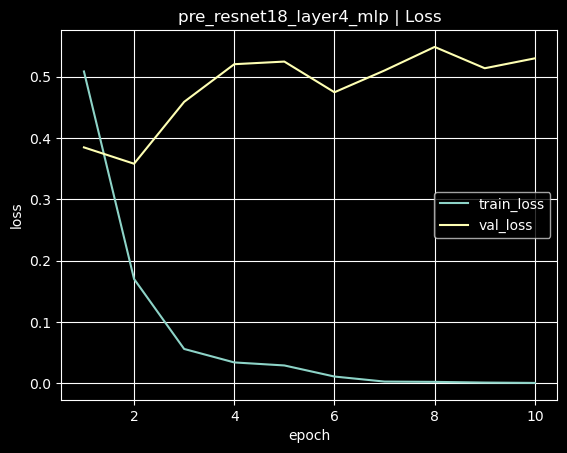

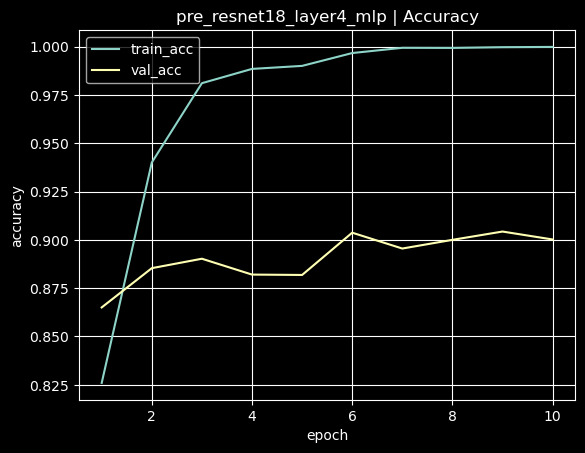

In [52]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

num_classes = 10
in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)
)

model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

for p in model.layer4.parameters():
    p.requires_grad = True

for p in model.fc.parameters():
    p.requires_grad = True

head_lr = 1e-3
backbone_lr = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    [
        {'params': model.layer4.parameters(), 'lr': backbone_lr},
        {'params': model.fc.parameters(), 'lr': head_lr}
    ], weight_decay=CFG.weight_decay
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

CFG.exp_name = 'pre_resnet18_layer4_mlp'
run_dir = make_run_dir(CFG)

history = fit(
    model, train_loader_pre, val_loader_pre,
    optimizer, criterion, device,
    epochs=CFG.epochs, run_dir=run_dir,
    scheduler=scheduler
)

plot_history(history, title=CFG.exp_name, run_dir=run_dir)

Адаптация фичей через layer4 реально дала сильный буст. Модель очень быстро переобучается на train, но всё равно обобщает хорошо.

Для борьбы с переобучением, добавим в MLP dropout

c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 01/10 | train_loss=0.5166, train_acc=0.8234 | val_loss=0.3567, val_acc=0.8732 | lr=0.0001
Epoch 02/10 | train_loss=0.1848, train_acc=0.9359 | val_loss=0.3624, val_acc=0.8883 | lr=0.0001
Epoch 03/10 | train_loss=0.0684, train_acc=0.9769 | val_loss=0.4385, val_acc=0.8854 | lr=0.0001
Epoch 04/10 | train_loss=0.0375, train_acc=0.9871 | val_loss=0.4964, val_acc=0.8914 | lr=0.0001
Epoch 05/10 | train_loss=0.0146, train_acc=0.9952 | val_loss=0.4601, val_acc=0.9045 | lr=0.0001
Epoch 06/10 | train_loss=0.0066, train_acc=0.9981 | val_loss=0.5121, val_acc=0.9004 | lr=0.0001
Epoch 07/10 | train_loss=0.0044, train_acc=0.9988 | val_loss=0.5390, val_acc=0.8992 | lr=0.0000
Epoch 08/10 | train_loss=0.0027, train_acc=0.9994 | val_loss=0.5310, val_acc=0.9010 | lr=0.0000
Epoch 09/10 | train_loss=0.0018, train_acc=0.9995 | val_loss=0.5418, val_acc=0.9014 | lr=0.0000
Epoch 10/10 | train_loss=0.0015, train_acc=0.9996 | val_loss=0.5478, val_acc=0.9031 | lr=0.0000


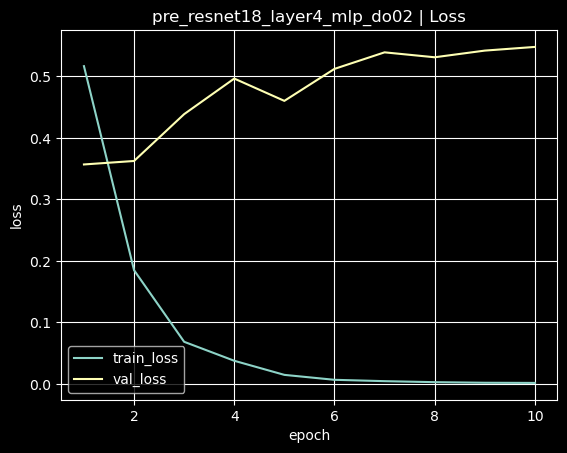

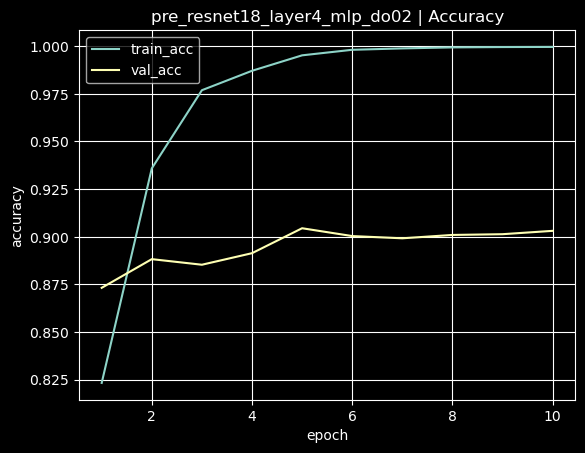

In [54]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

num_classes = 10
in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(256, num_classes)
)

model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

backbone_lr = 1e-4
head_lr = 1e-3

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': backbone_lr},
    {'params': model.fc.parameters(),     'lr': head_lr},
], weight_decay=CFG.weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

CFG.exp_name = 'pre_resnet18_layer4_mlp_do02'
run_dir = make_run_dir(CFG)

history = fit(
    model, train_loader_pre, val_loader_pre,
    optimizer, criterion, device,
    epochs=CFG.epochs, run_dir=run_dir,
    scheduler=scheduler
)

plot_history(history, title=CFG.exp_name, run_dir=run_dir)

val_loss всё равно растёт после пика, но модель держит 0.90 стабильнее